In [192]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import loadmat
from scipy.special import gamma
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.patches as patches
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [193]:
def embedding_fit_metrics(original_distances, embedded_distances):
    """
    Computes the following goodness-of-fit metrics for an embedding:
    1. Spearman's Rank Correlation
    2. Pearson Correlation
    3. R^2 value (MSE to the line y = x)

    Parameters:
    original_distances (array-like): Pairwise distances in the original space.
    embedded_distances (array-like): Pairwise distances in the embedded space.

    Returns:
    dict: A dictionary containing Spearman's rho, Pearson's r, and R^2 value.
    """
    
    # Ensure input is NumPy arrays
    original_distances = np.array(original_distances)
    embedded_distances = np.array(embedded_distances)
    
    # Compute Spearman's rank correlation
    spearman_corr, _ = spearmanr(original_distances, embedded_distances)
    
    # Compute Pearson correlation
    pearson_corr, _ = pearsonr(original_distances, embedded_distances)
    
    # Compute R^2 value (MSE to the line y = x)
    r2 = r2_score(original_distances, embedded_distances)
    
    return {
        "Spearman Rank Correlation": spearman_corr,
        "Pearson Correlation": pearson_corr,
        "R^2 Value": r2
    }

In [194]:
def vol(R, D):
    c = 2*np.power(np.pi, 0.5*D) 
    itg = integrate.quad(lambda x: np.power(np.sinh(x), D-1), 0.0, R)[0]
    return c*itg

def sample_r(R, D):
    rmin = 0.0; rmax = R; rc = 0.5*R
    V_tot = vol(R, D); uc = vol(rc, D)/V_tot
    u = np.random.uniform()
    while(np.abs(u-uc)>1e-4):
        if uc < u:
            rmin = rc
            rc = 0.5*(rc + rmax)
            uc = vol(rc, D)/V_tot
        elif u < uc:
            rmax = rc
            rc = 0.5*(rc + rmin)
            uc = vol(rc, D)/V_tot
    return rc

#uniformly sample a point in hyperbolic space out to Rmax
#return point in poincare coords
def h_samp(rm, D):
    direction = np.random.normal(size=D)
    direction = direction/np.sqrt(np.sum(np.square(direction)))
    #th = 2.0*np.pi*np.random.uniform()
    r_p = sample_r(rm, 2)
    return np.tanh(r_p/2.0)*direction
    #return np.tanh(r_p/2.0)*np.asarray([np.cos(th), np.sin(th)])

def pdist(p1, p2):
    inv = 2.0*(p1-p2).dot(p1-p2)/((1-p1.dot(p1))*(1-p2.dot(p2)))
    return np.arccosh(1.0 + inv)

In [195]:
class HMDS():
    def __init__(self, deltaij, D, a=2, b=0.5, sig_lam=10, tolerance=1e-10):
        ## Parameters ##
        self.deltaij = tf.constant(deltaij, dtype=tf.float32)
        self.N = tf.constant(deltaij.shape[0])
        self.D = tf.constant(D)

        ## Variables ##
        self.euc = tf.Variable(tf.random.normal(shape=(self.N, self.D), mean=0.0, stddev=.0001), dtype=tf.float32)
        self.log_sig = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), dtype=tf.float32)
        self.log_lam = tf.Variable(0, dtype=tf.float32)

        ## Constraints ##
        self.time = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), shape=(self.N,1), trainable=False)

        ## Model Hyperparameters ##
        self.a = a
        self.b = b
        self.sig_lam = sig_lam

        ## Optimization Hyperparameters ##
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.tolerance = tolerance

        ## Optimization Results ##
        self.loss_curve = []
        self.lambda_curve = []
        
    @tf.function
    def constraint_time(self):
        return tf.expand_dims(tf.sqrt(tf.add(1.0,tf.square(tf.norm(self.euc,axis=1)))),1)

    @tf.function
    def pairwise_dist_lorentz(self):
        self.time = self.constraint_time()
        time_product = tf.matmul(self.time, self.time, transpose_b=True)
        space_product = tf.matmul(self.euc, self.euc, transpose_b=True)
        lorentzian_inner_product = time_product - space_product
        lorentzian_inner_product_clipped = tf.maximum(lorentzian_inner_product, 1.0+1e-7)
        distance_matrix = tf.math.acosh(lorentzian_inner_product_clipped) + 1e-12
        return distance_matrix
        
    @tf.function
    def loss(self):
        dist = self.pairwise_dist_lorentz()
        s2 = tf.transpose(tf.square(tf.math.exp(self.log_sig))) + tf.square(tf.math.exp(self.log_sig)) + 1e-12
        stress = tf.divide(tf.square(tf.divide(dist,tf.math.exp(self.log_lam)) - self.deltaij),s2)
        lkl = tf.add(stress, tf.math.log(tf.scalar_mul(2*np.pi, s2)))
        mask = tf.cast(tf.linalg.band_part(tf.ones_like(lkl),0, -1) - tf.eye(tf.shape(lkl)[0]), dtype=tf.bool)
        lkl_upper = tf.boolean_mask(lkl,mask)
        prior_lam = tf.scalar_mul(tf.divide(tf.cast(self.N*(self.N-1),tf.float32),4*(self.sig_lam**2)),tf.math.exp(self.log_lam)**2)
        prior_sig = tf.reduce_sum(tf.scalar_mul((self.a + 1), self.log_sig) + tf.divide(self.b, tf.math.exp(self.log_sig)))
        return 0.5*tf.reduce_sum(lkl_upper) + prior_lam + prior_sig + tf.reduce_sum(self.log_sig) + self.log_lam

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            loss_value = self.loss()
        grads = tape.gradient(loss_value, [self.euc, self.log_sig, self.log_lam])
        self.optimizer.apply_gradients(zip(grads, [self.euc, self.log_sig, self.log_lam]))
        gradient_norm = tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in grads])
        return loss_value, gradient_norm

    def train(self, n=50000):
        for epoch in range(n):
            loss_val, gradient_norm = self.train_step()
            self.loss_curve.append(loss_val)
            self.lambda_curve.append(np.exp(self.log_lam.numpy()))
            if epoch % 5000 == 0:
                print(f'epoch {epoch}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}')
            if gradient_norm < self.tolerance:
                print(f"Converged at epoch {epoch + 1}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}")
                break  # Stop training

    ## Visualization ##
    def plot_loss(self):
        plt.figure()
        plt.plot(self.loss_curve)
        plt.xlabel('Step')
        plt.ylabel('-Log Likelihood')
        plt.show()

    def plot_lambda(self):
        plt.figure()
        plt.plot(self.lambda_curve)
        plt.xlabel('Step')
        plt.ylabel('Lambda')
        plt.show()

    def plot_sigmas(self):
        plt.figure()
        plt.hist(np.exp(self.log_sig.numpy()))
        plt.xlabel('Sigma')
        plt.ylabel('Counts')
        plt.show()

    def shepard(self):
        plt.figure()
        plt.scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.pairwise_dist_lorentz().numpy()[np.triu_indices(self.N,k=1)]/np.exp(self.log_lam))
        plt.xlabel('True Distance')
        plt.ylabel('Embedding Distance')
        plt.show()

    def get_poin(self):
        ts = np.sqrt(1.0 + np.sum(np.square(self.euc.numpy()), axis=1))
        p_coords = (self.euc.numpy().T / (ts + 1)).T
        return p_coords

    ## Metrics ##
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())
        lam = np.exp(self.log_lam.numpy())
        emb_mat = self.pairwise_dist_lorentz().numpy()
        
        for i in np.arange(N):
            for j in np.arange(i+1, N):
                seff = sigs[i]**2 + sigs[j]**2
                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi)
        return lkl[0]

    def BIC(self):
        N, D = self.N.numpy(), self.D.numpy()
        n = 0.5*N*(N-1)
        k = N*D + N + 1.0 - 0.5*D*(D-1)
        return float(k*np.log(n) + 2.0*self.MDS_lkl())

In [196]:
class nonmetricHMDS():
    def __init__(self, deltaij, D, Ns, a=2, b=0.5, sig_lam=10, sig_w=1, sig_b=10, sig_s=10,  tolerance=1e-10):
        ## Parameters ##
        self.deltaij = tf.constant(deltaij, dtype=tf.float32)
        self.N = tf.constant(deltaij.shape[0])
        self.D = tf.constant(D)
        self.Ns = tf.constant(Ns)

        ## Variables ##
        self.euc = tf.Variable(tf.random.normal(shape=(self.N, self.D), mean=0.0, stddev=.0001), dtype=tf.float32)
        self.log_sig =tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), dtype=tf.float32)
        self.log_w = tf.Variable(np.log(np.ones(self.Ns)/Ns), dtype=tf.float32)
        self.log_b = tf.Variable(tf.random.normal([self.Ns], mean=0, stddev=0.001), dtype=tf.float32)
        self.log_s = tf.Variable(np.log(np.linspace(1/self.Ns,1+1/self.Ns,self.Ns)), dtype=tf.float32)

        ## Constraints ##
        self.time = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), shape=(self.N,1), trainable=False)

        ## Model Hyperparameters ##
        self.a = a
        self.b = b
        self.sig_w = sig_w
        self.sig_b = sig_b
        self.sig_s = sig_s

        ## Optimization Hyperparameters ##
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.tolerance = tolerance

        ## Optimization Results ##
        self.loss_curve = []

    @tf.function
    def constraint_time(self):
        return tf.expand_dims(tf.sqrt(tf.add(1.0,tf.square(tf.norm(self.euc,axis=1)))),1)

    @tf.function
    def pairwise_dist_lorentz(self):
        self.time = self.constraint_time()
        time_product = tf.matmul(self.time, self.time, transpose_b=True)
        space_product = tf.matmul(self.euc, self.euc, transpose_b=True)
        lorentzian_inner_product = time_product - space_product
        lorentzian_inner_product_clipped = tf.maximum(lorentzian_inner_product, 1.0+1e-7)
        distance_matrix = tf.math.acosh(lorentzian_inner_product_clipped) + 1e-12
        return distance_matrix

    @tf.function
    def sigmoid(self,x):
        return tf.math.sigmoid(4*x)

    @tf.function
    def monotonic(self,x):
        dist_s = tf.expand_dims(x, axis=-1) - tf.math.exp(tf.expand_dims(self.log_s, axis=0))
        dist_bs = tf.multiply(dist_s,tf.math.exp(tf.expand_dims(self.log_b, axis=0)))
        sig = self.sigmoid(dist_bs)
        transformed_dist = tf.multiply(sig,tf.math.exp(tf.expand_dims(self.log_w, axis=0)))
        return tf.reduce_sum(transformed_dist, axis=-1)
        
    @tf.function
    def loss(self):
        dist = self.pairwise_dist_lorentz()
        trans_dist =  self.monotonic(dist)
        s2 = tf.transpose(tf.square(tf.math.exp(self.log_sig))) + tf.square(tf.math.exp(self.log_sig)) + 1e-12
        stress = tf.divide(tf.square(trans_dist - self.deltaij),s2)
        lkl = tf.add(stress, tf.math.log(tf.scalar_mul(2*np.pi, s2)))
        mask = tf.cast(tf.linalg.band_part(tf.ones_like(lkl),0, -1) - tf.eye(tf.shape(lkl)[0]), dtype=tf.bool)
        lkl_upper = tf.boolean_mask(lkl,mask)
        prior_sig = tf.reduce_sum(tf.scalar_mul((self.a + 1), self.log_sig) + tf.divide(self.b, tf.math.exp(self.log_sig)))
        return 0.5*tf.reduce_sum(lkl_upper) + prior_sig + tf.reduce_sum(self.log_sig) + tf.reduce_sum(self.log_w) + tf.reduce_sum(self.log_b) + tf.reduce_sum(self.log_s)# + self.log_lam + prior_lam + 

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            loss_value = self.loss()
        grads = tape.gradient(loss_value, [self.euc, self.log_sig, self.log_w, self.log_b, self.log_s])
        self.optimizer.apply_gradients(zip(grads, [self.euc, self.log_sig, self.log_w, self.log_b, self.log_s]))
        gradient_norm = tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in grads])
        return loss_value, gradient_norm

    def train(self, n=50000):
        self.plot_transformation()
        for epoch in range(n):
            loss_val, gradient_norm = self.train_step()
            self.loss_curve.append(loss_val)
            if epoch % 5000 == 0:
                print(f'epoch {epoch}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}')
            if gradient_norm < self.tolerance:
                print(f"Converged at epoch {epoch + 1}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}")
                break  # Stop training

    ## Visualization ##
    def plot_loss(self):
        plt.figure()
        plt.plot(self.loss_curve)
        plt.xlabel('Step')
        plt.ylabel('-Log Likelihood')
        plt.show()

    def plot_transformation(self):
        plt.figure()
        maxDist = np.max(self.pairwise_dist_lorentz().numpy())
        x = np.linspace(0-5,maxDist+10,100,dtype=np.float32)
        plt.plot(x,self.monotonic(x))
        plt.vlines(maxDist,0,self.monotonic(maxDist),linestyles='dashed',color='red')
        plt.xlabel('Input Distance')
        plt.ylabel('Output Distance')
        plt.show()

    def plot_sigmas(self):
        plt.figure()
        plt.hist(np.exp(self.log_sig.numpy()))
        plt.xlabel('Sigma')
        plt.ylabel('Counts')
        plt.show()

    def shepard(self):
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.pairwise_dist_lorentz().numpy()[np.triu_indices(self.N,k=1)])
        ax[0].set_xlabel('True Distance')
        ax[0].set_ylabel('Embedding Distance')
        ax[1].scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.monotonic(self.pairwise_dist_lorentz()).numpy()[np.triu_indices(self.N,k=1)])
        ax[1].plot([0,1],[0,1],linestyle='--')
        ax[1].set_xlabel('True Distance')
        ax[1].set_ylabel('Transformed Embedding Distance')
        plt.show()

    def get_poin(self):
        ts = np.sqrt(1.0 + np.sum(np.square(self.euc.numpy()), axis=1))
        p_coords = (self.euc.numpy().T / (ts + 1)).T
        return p_coords
    
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()                             # Original dissimilarities δᵢⱼ
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())                     # σᵢ values
        emb_mat = self.pairwise_dist_lorentz().numpy()          # Raw hyperbolic distances
        transformed = self.monotonic(emb_mat).numpy()           # f(dᵢⱼ)

        for i in np.arange(N):
            for j in np.arange(i+1, N):
                seff = sigs[i]**2 + sigs[j]**2 + 1e-12           # σᵢ² + σⱼ²
                diff = dmat[i][j] - transformed[i][j]            # δᵢⱼ - f(dᵢⱼ)
                lkl += (diff**2 / (2.0 * seff)) + 0.5 * np.log(seff * 2.0 * np.pi)

        return lkl

    def BIC(self):
        N = self.N.numpy()
        D = self.D.numpy()
        Ns = self.Ns.numpy()
        n = 0.5 * N * (N - 1)                         # Number of pairwise observations

        # Number of parameters:
        # - N * D       : embedding coordinates
        # - N           : uncertainty values (log_sig)
        # - 3 * Ns      : parameters for f(x): log_w, log_b, log_s
        k = N * D + N + 3 * Ns

        # Negative log-likelihood using monotonic f(x)
        lkl = self.MDS_lkl()

        # Bayesian Information Criterion
        BIC = k * np.log(n) + 2 * lkl
        return float(BIC)


'''
    ## Metrics ##
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()               # Original dissimilarities
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())       # Uncertainty per point (σᵢ)
        lam = np.exp(self.log_lam.numpy())        # Curvature scale (λ)
        emb_mat = self.pairwise_dist_lorentz().numpy()   # Hyperbolic distances
        
        for i in np.arange(N):      # Loop Over Upper Triangle of Distance Matrix
            for j in np.arange(i+1, N):     
                seff = sigs[i]**2 + sigs[j]**2
                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi) # This is the negative log-likelihood for a normal distribution,,, so we are assuming delta_ij belongs to normal dist which is a metric assumption?
        return lkl[0] # isn't lkl a scalar? it should return just lkl

    def BIC(self):
        N, D = self.N.numpy(), self.D.numpy()
        n = 0.5*N*(N-1)
        k = N*D + N + 1.0 - 0.5*D*(D-1)
        return float(k*np.log(n) + 2.0*self.MDS_lkl())
'''



"\n    ## Metrics ##\n    def MDS_lkl(self):\n        lkl = 0\n        dmat = self.deltaij.numpy()               # Original dissimilarities\n        N = self.N.numpy()\n        sigs = np.exp(self.log_sig.numpy())       # Uncertainty per point (σᵢ)\n        lam = np.exp(self.log_lam.numpy())        # Curvature scale (λ)\n        emb_mat = self.pairwise_dist_lorentz().numpy()   # Hyperbolic distances\n        \n        for i in np.arange(N):      # Loop Over Upper Triangle of Distance Matrix\n            for j in np.arange(i+1, N):     \n                seff = sigs[i]**2 + sigs[j]**2\n                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi) # This is the negative log-likelihood for a normal distribution,,, so we are assuming delta_ij belongs to normal dist which is a metric assumption?\n        return lkl[0] # isn't lkl a scalar? it should return just lkl\n\n    def BIC(self):\n        N, D = self.N.numpy(), self.D.numpy()\n        n = 0.5*N*

In [197]:
N = 100
pts = np.asarray([h_samp(0.05, 3) for i in np.arange(N)])
print(pts.shape)
dmat = np.zeros((100,100))

for i in np.arange(100):
    for j in np.arange(i+1, 100):
        dmat[i][j] = pdist(pts[i], pts[j])
        dmat[j][i] = dmat[i][j]

dmat = dmat #+ 0.1*np.random.normal(size=(100,100))

dmat = dmat/np.max(dmat)
#dmat = np.arcsin(dmat) # deliberately violate the properties of a metric (like the triangle inequality) — because real-world data often doesn't obey perfect metric assumptions.
#dmat = np.sin((np.pi/2)*dmat)
dmat = dmat/np.max(dmat)
# Use arcsin to get strong curvature-like effects while preserving smoothness and rank. and controlled range. 
## It's convex on [0, 1], meaning small distances get expanded more than large ones. 

(100, 3)


(array([ 54., 297., 602., 860., 978., 871., 627., 434., 190.,  37.]),
 array([0.00932229, 0.10839006, 0.20745783, 0.3065256 , 0.40559337,
        0.50466114, 0.60372891, 0.70279669, 0.80186446, 0.90093223,
        1.        ]),
 <BarContainer object of 10 artists>)

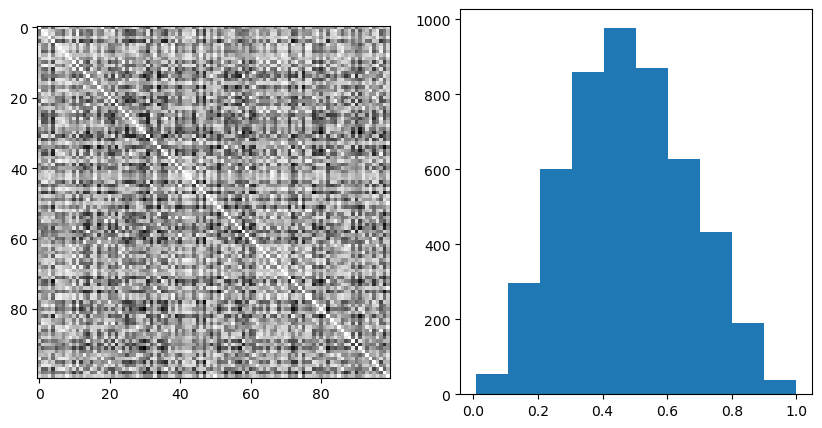

In [198]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(dmat, cmap='Greys')
ax[1].hist(dmat[np.triu_indices(N,k=1)])

In [199]:
testnmHMDS = nonmetricHMDS(dmat,3,3)

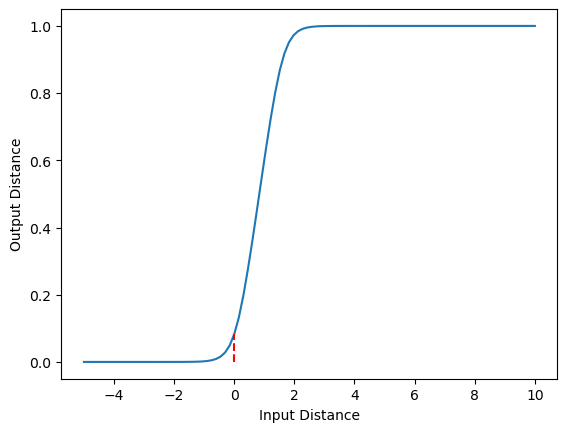

epoch 0, Loss: 6547.203125, normG: 251485.390625
epoch 5000, Loss: -13091.474609375, normG: 1108746.0
epoch 10000, Loss: -13330.2861328125, normG: 6695.04052734375
epoch 15000, Loss: -13348.18359375, normG: 675488.625
epoch 20000, Loss: -13356.021484375, normG: 100333.0625
epoch 25000, Loss: -13356.12109375, normG: 72851480.0
epoch 30000, Loss: -13362.7060546875, normG: 3935.107421875
epoch 35000, Loss: -13364.388671875, normG: 3342.325439453125
25.72365689277649


In [200]:
now = time.time()
testnmHMDS.train(n=40000)
print(time.time() - now)

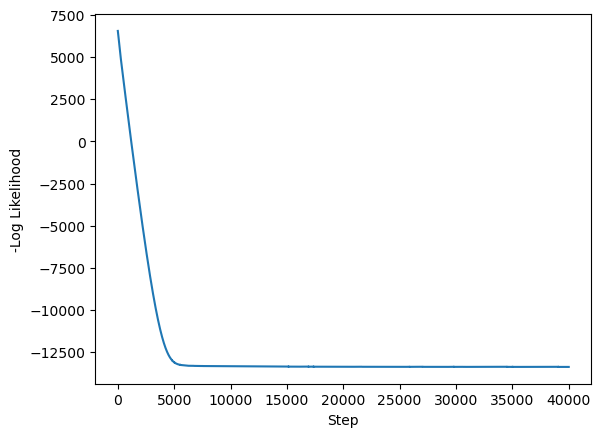

In [201]:
testnmHMDS.plot_loss()

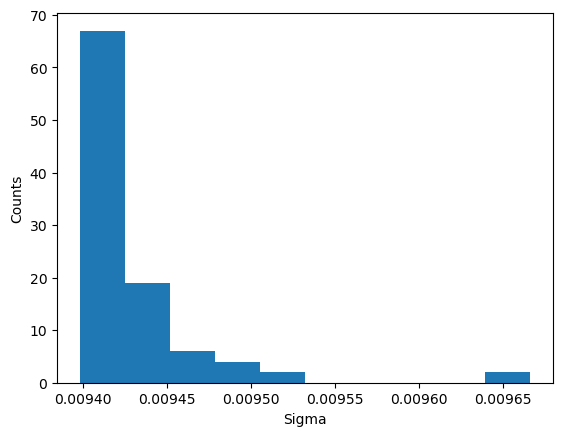

In [202]:
testnmHMDS.plot_sigmas()

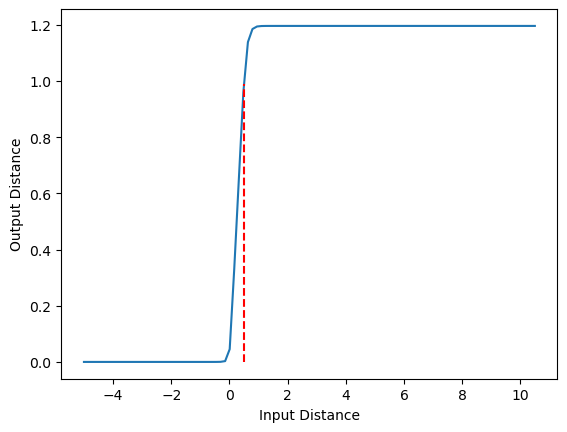

In [203]:
testnmHMDS.plot_transformation()

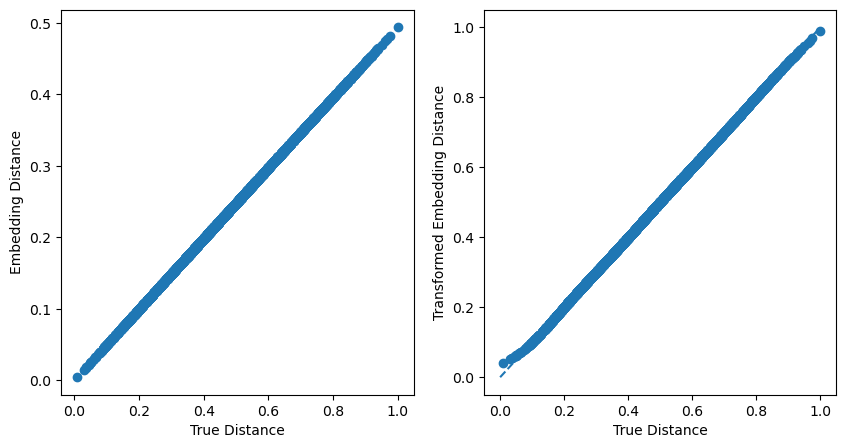

In [204]:
testnmHMDS.shepard()

(100, 3)


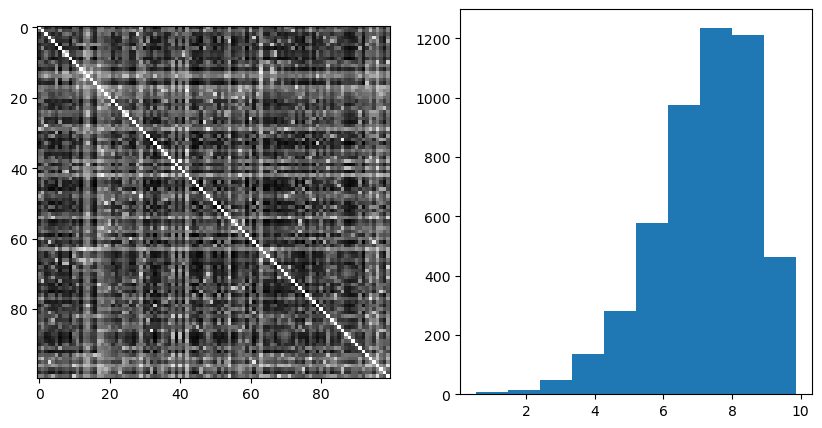

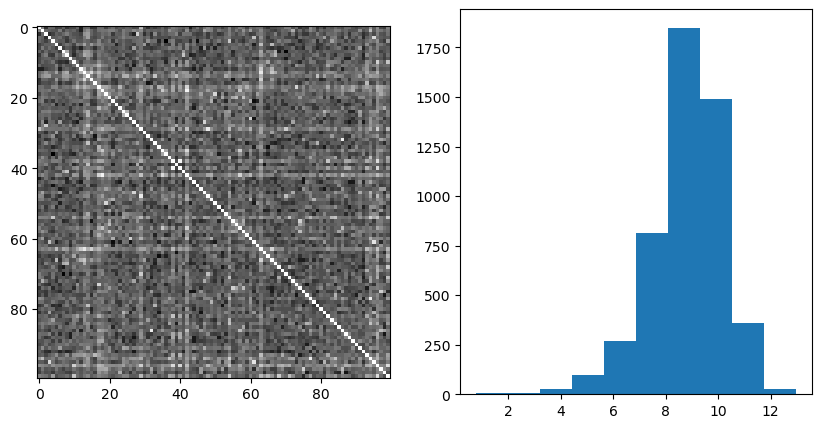

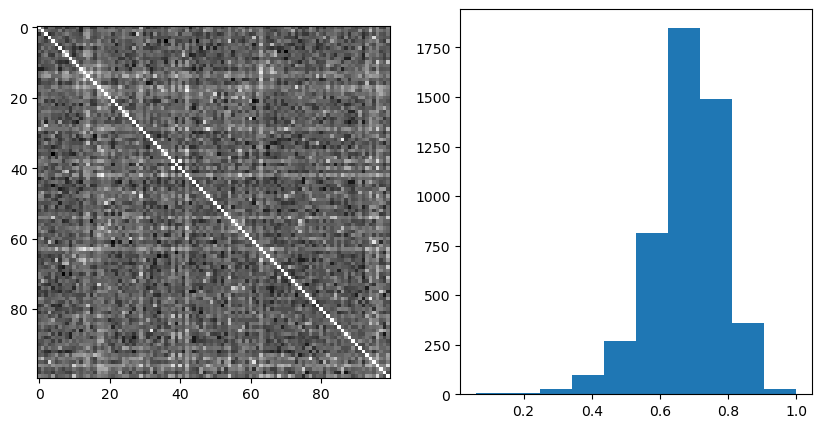

In [263]:
N = 100
pts = np.asarray([h_samp(5.0, 3) for i in np.arange(N)])
print(pts.shape)
dmat = np.zeros((N,N))

for i in np.arange(N):
    for j in np.arange(i+1, N):
        dmat[i][j] = pdist(pts[i], pts[j])
        dmat[j][i] = dmat[i][j]
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(dmat, cmap='Greys')
ax[1].hist(dmat[np.triu_indices(N,k=1)])
plt.show()

Noisy_dmat = np.zeros((N,N))
for i in np.arange(N):
    for j in np.arange(i+1, N):
        Noisy_dmat[i][j] = Noisy_dmat[j][i] = dmat[i][j]
        #if dmat[i,j] >= 6:
        Noisy_dmat[i][j] = 10*np.sin((np.pi/20)*(dmat[i][j]))+np.random.normal(0,dmat[i][j]/10)
        #Noisy_dmat[i][j] = dmat[i][j] + np.random.normal(0,1/(dmat[i][j]/0.5))
        Noisy_dmat[j][i] = Noisy_dmat[i][j]

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(Noisy_dmat, cmap='Greys')
ax[1].hist(Noisy_dmat[np.triu_indices(N,k=1)])
plt.show()
        
#dmat = dmat + 0.1*np.random.normal(size=(100,100))
Noisy_dmat = Noisy_dmat/np.max(Noisy_dmat)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(Noisy_dmat, cmap='Greys')
ax[1].hist(Noisy_dmat[np.triu_indices(N,k=1)])
plt.show()

(array([  4.,   9.,  19.,  51., 106., 240., 388., 336.,  65.,   7.]),
 array([0.13209139, 0.21671966, 0.30134792, 0.38597619, 0.47060446,
        0.55523273, 0.639861  , 0.72448927, 0.80911754, 0.89374581,
        0.97837408]),
 <BarContainer object of 10 artists>)

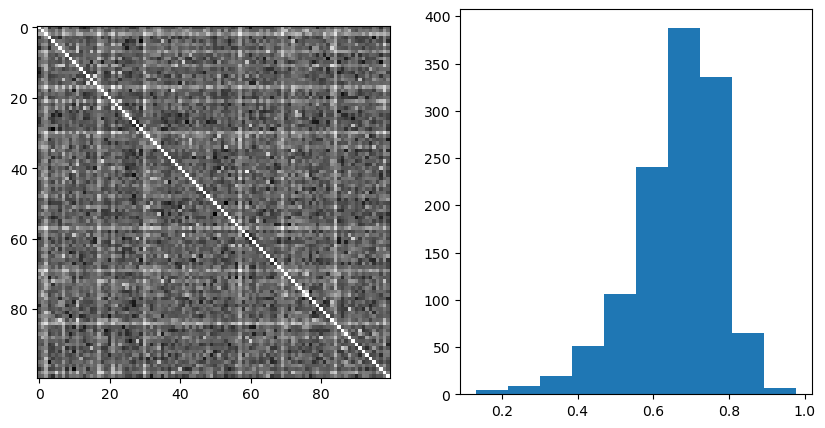

In [206]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(Noisy_dmat, cmap='Greys')
ax[1].hist(Noisy_dmat[np.triu_indices(50,k=1)])

In [207]:
testnmHMDS = nonmetricHMDS(dmat,3,10)

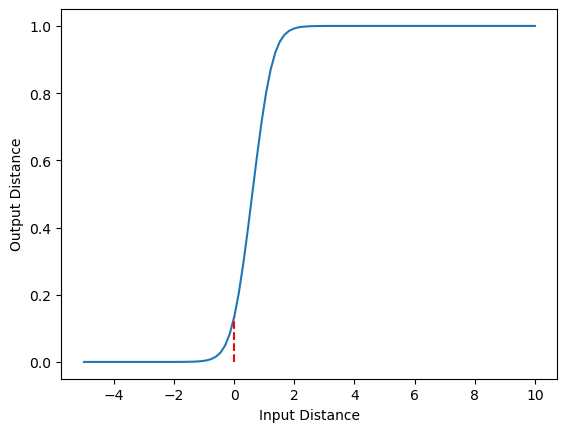

epoch 0, Loss: 68913.65625, normG: 154498480.0
epoch 5000, Loss: 7732.78759765625, normG: 25790.259765625
epoch 10000, Loss: -670.3770751953125, normG: 51668.33984375
epoch 15000, Loss: -4469.54833984375, normG: 204083952.0
epoch 20000, Loss: -5170.6416015625, normG: 6792158.5
epoch 25000, Loss: -5627.1337890625, normG: 734865664.0
24.34091019630432


In [208]:
now = time.time()
testnmHMDS.train(n=30000)
print(time.time() - now)

normG = Total Gradient Norm = is the sum of squared gradients of all learnable parameter : Track how "steep" the loss surface is
when normG is small, gradients are vanishing → training is stabilizing

?? tuning learning rate or improving initialization could help ??

For negative log loss I'm summing over N Choose 2 ~ 4950 pairs

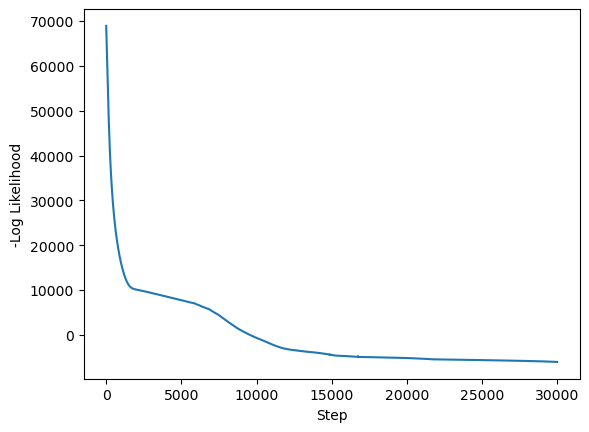

In [209]:
testnmHMDS.plot_loss()

why did this plateau for so many steps in between?

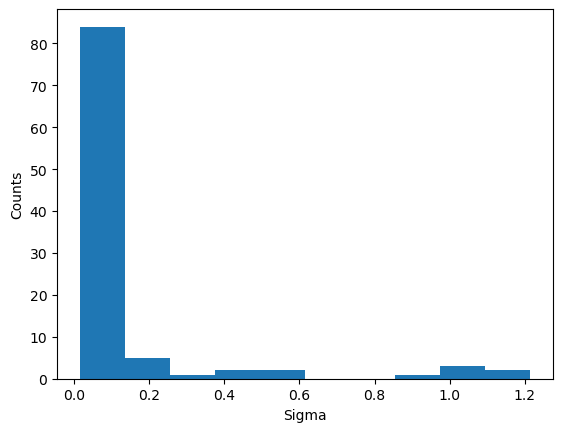

In [210]:
testnmHMDS.plot_sigmas()

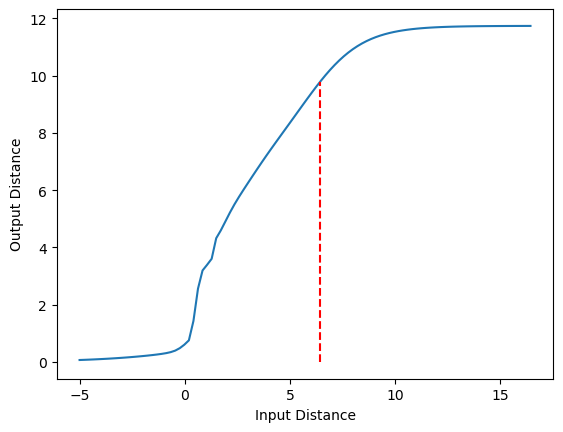

In [211]:
testnmHMDS.plot_transformation()

function must be smooth, no?

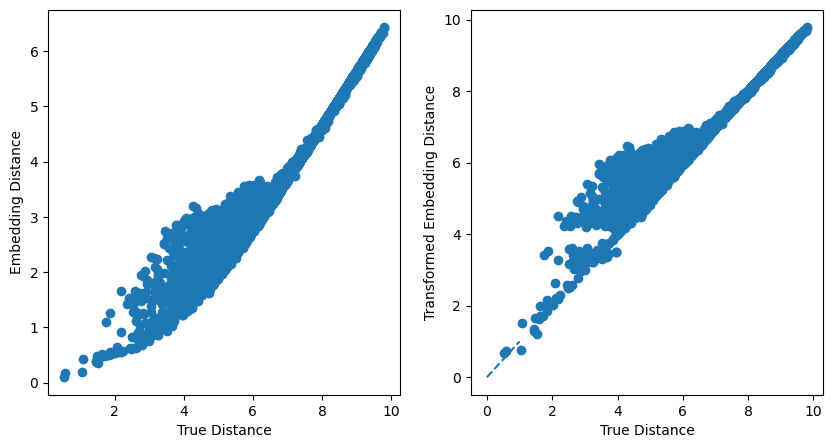

In [212]:
testnmHMDS.shepard()

I should make the above onotonic function plot for the normalized input distance instead of the true input distance because then I will be able to match the kinks to the flat lines in the shepard diagram of transformed distances to the monotonic functon graph

no but the flat lines can't be due to the monotonic funciton because I can see those flat lines in the untransformed embedding distance ka graph as well

a variety of true distances are being fit to the same embedding distances

In [213]:
nmHMDS = nonmetricHMDS(dmat,3,3)

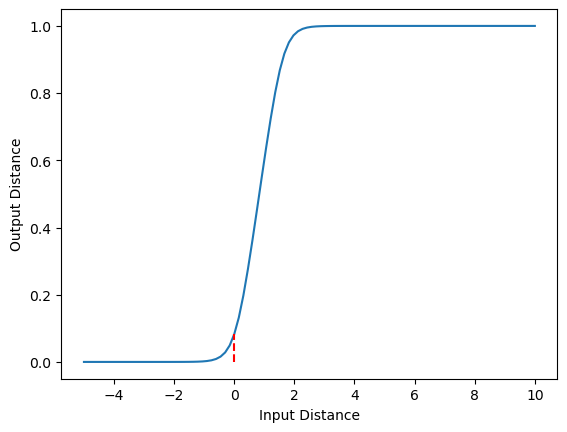

epoch 0, Loss: 69838.6015625, normG: 162141680.0
epoch 5000, Loss: 6058.67626953125, normG: 145958.453125
epoch 10000, Loss: -3721.7314453125, normG: 14146157.0
epoch 15000, Loss: -5844.72216796875, normG: 11857964.0
epoch 20000, Loss: -7042.94970703125, normG: 48983.67578125
epoch 25000, Loss: -7885.7568359375, normG: 5239881.0
epoch 30000, Loss: -8504.6875, normG: 490966.0
epoch 35000, Loss: -8995.2109375, normG: 212959344.0
epoch 40000, Loss: -9436.32421875, normG: 1473588864.0
epoch 45000, Loss: -9869.041015625, normG: 26728532.0
31.730657815933228


In [214]:
now = time.time()
nmHMDS.train(n=50000)
print(time.time() - now)

This plot shows the initial learned monotonic transformation f(x), which maps raw hyperbolic distances d_ij  to predicted dissimilarities δ_ij
Was generated by plot_transformation funciton
X-axis = input distances from the embedding
Y-axis = output distances = transformed distances via your learned function
The blue curve is your model’s current f(x)
This is using only 2 steps N_s = 2, and weights are equal = 0.5, and default initialization is near 0,, therefore I get something close to f(x) ~ sigmoid(x)

Red line tells: My training data only contains distances up to this point -- but I don't really understand that!
Everything to the right of this line is extrapolation — the model is learning f(x) beyond the domain it sees
As training progresses: The steps in f(x) (controlled by log_w, log_b, log_s) will move around.

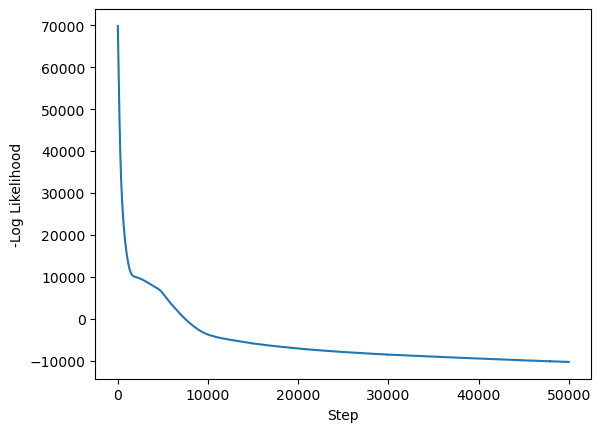

In [215]:
nmHMDS.plot_loss()

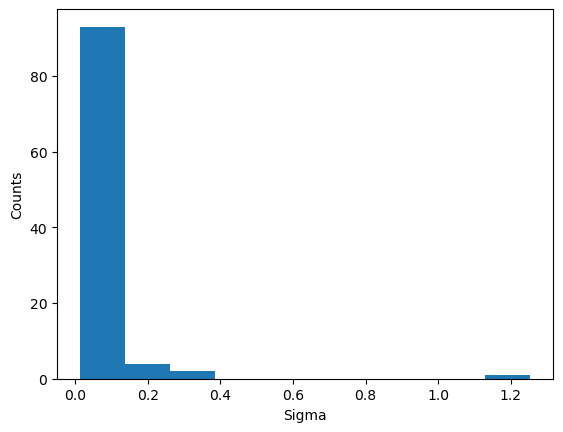

In [216]:
nmHMDS.plot_sigmas()

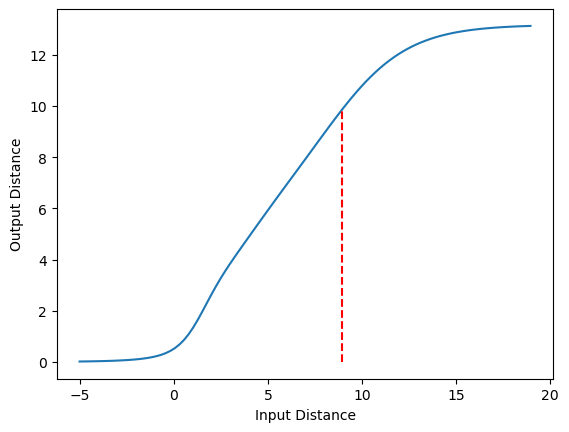

In [217]:
nmHMDS.plot_transformation()

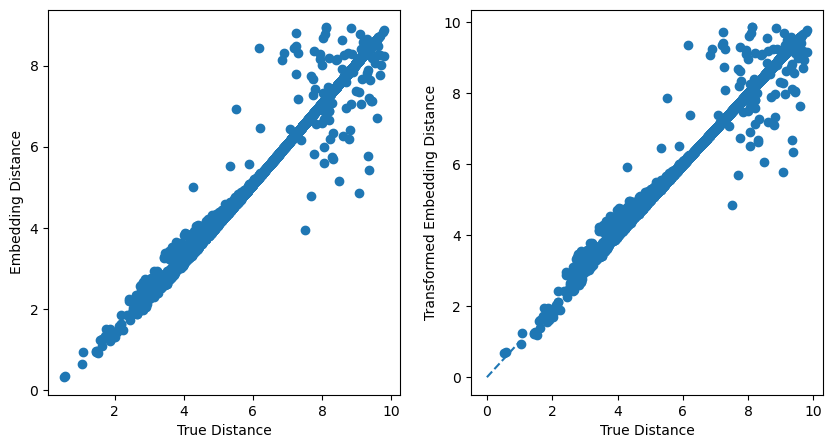

In [218]:
nmHMDS.shepard()

In [219]:
nmHMDS = nonmetricHMDS(dmat,3,5)

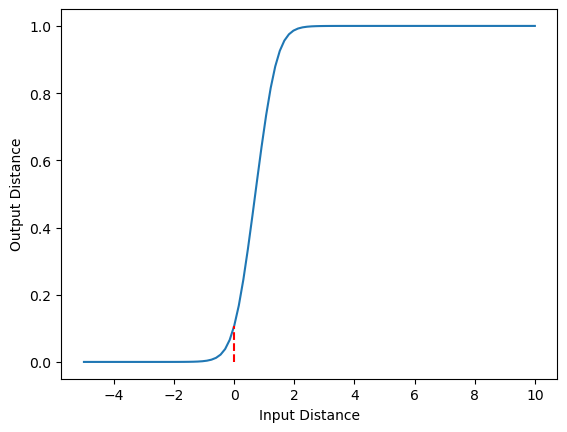

epoch 0, Loss: 69383.140625, normG: 158321392.0
epoch 5000, Loss: 7729.6748046875, normG: 29218.314453125
epoch 10000, Loss: -249.71095275878906, normG: 44496.40625
epoch 15000, Loss: -4259.39697265625, normG: 1682986.0
epoch 20000, Loss: -5938.68701171875, normG: 8058314.5
epoch 25000, Loss: -7194.3828125, normG: 1664571.5
epoch 30000, Loss: -8134.7822265625, normG: 1412368000.0
epoch 35000, Loss: -8796.33203125, normG: 62501236.0
epoch 40000, Loss: -9241.876953125, normG: 263988.0
epoch 45000, Loss: -9630.1474609375, normG: 1888905.75
29.724287033081055


In [220]:
now = time.time()
nmHMDS.train(n=50000)
print(time.time() - now)

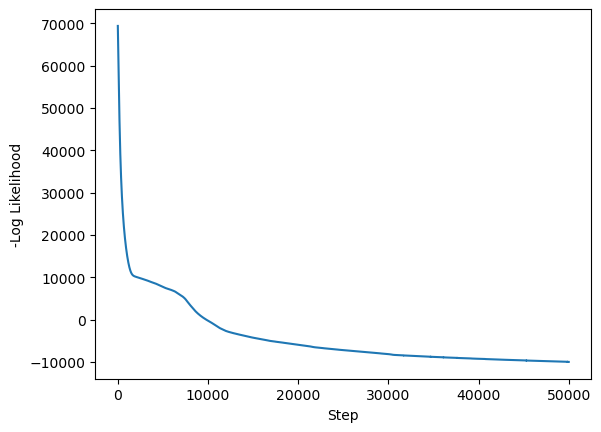

In [221]:
nmHMDS.plot_loss()

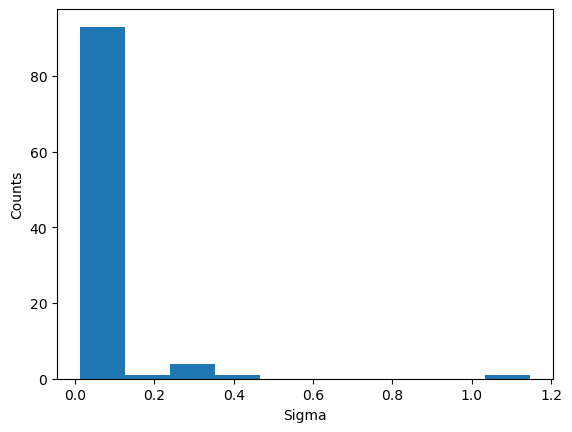

In [222]:
nmHMDS.plot_sigmas()

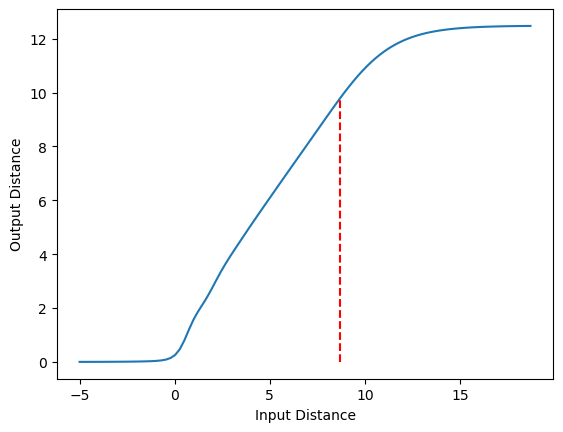

In [223]:
nmHMDS.plot_transformation()

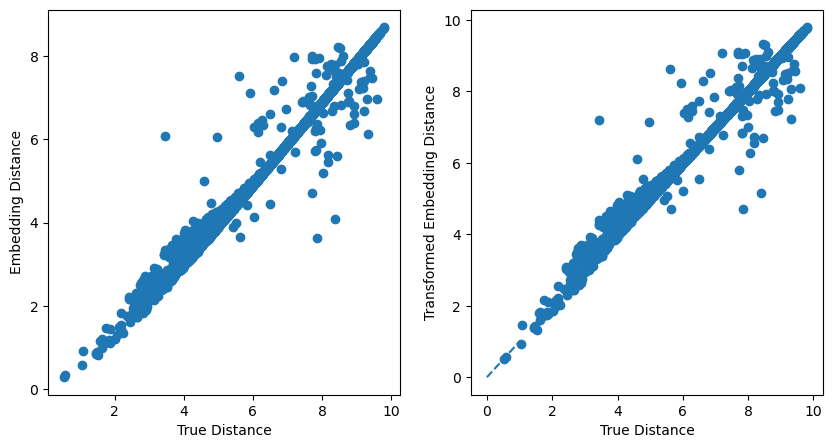

In [224]:
nmHMDS.shepard()

In [266]:
nmHMDS_noisy = nonmetricHMDS(Noisy_dmat,3,5)

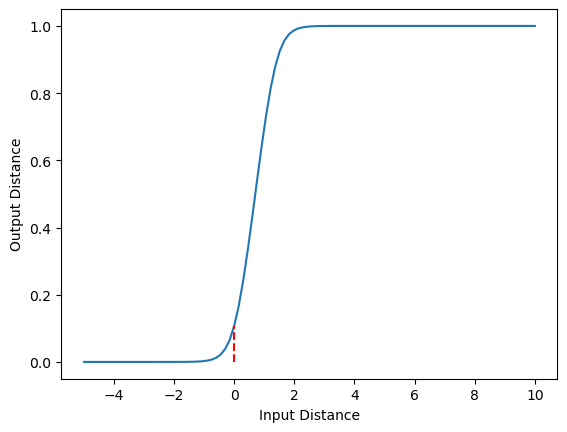

epoch 0, Loss: 6723.58056640625, normG: 226710.875
epoch 5000, Loss: -6980.95654296875, normG: 266.60614013671875
epoch 10000, Loss: -7249.7392578125, normG: 28.613611221313477
epoch 15000, Loss: -7357.9619140625, normG: 20.061697006225586
epoch 20000, Loss: -7428.16455078125, normG: 16.566246032714844
epoch 25000, Loss: -7495.27880859375, normG: 9.686773300170898
19.93019199371338


In [267]:
now = time.time()
nmHMDS_noisy.train(n=30000)
print(time.time() - now)

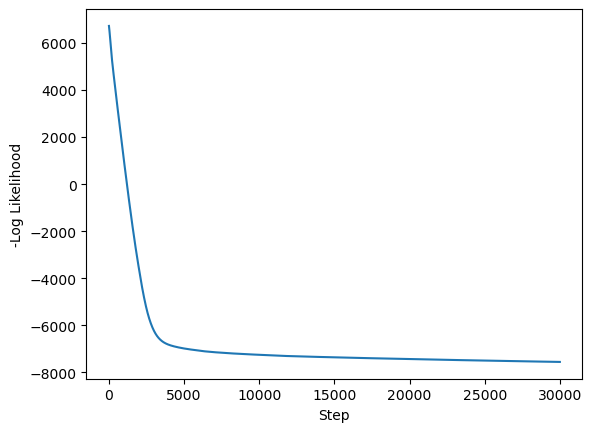

In [268]:
nmHMDS_noisy.plot_loss()

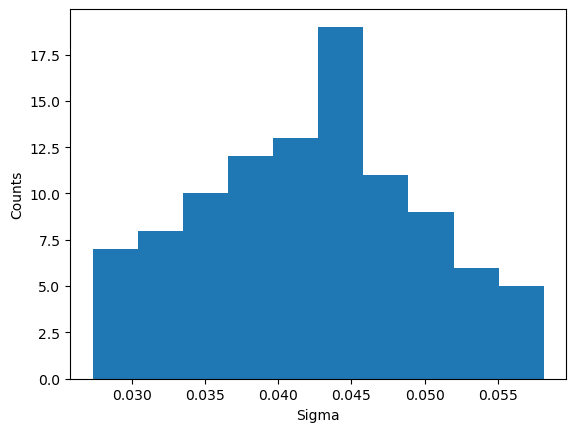

In [269]:
nmHMDS_noisy.plot_sigmas()

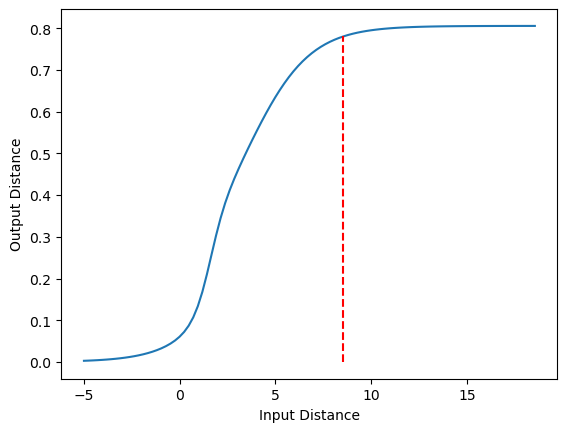

In [270]:
nmHMDS_noisy.plot_transformation()

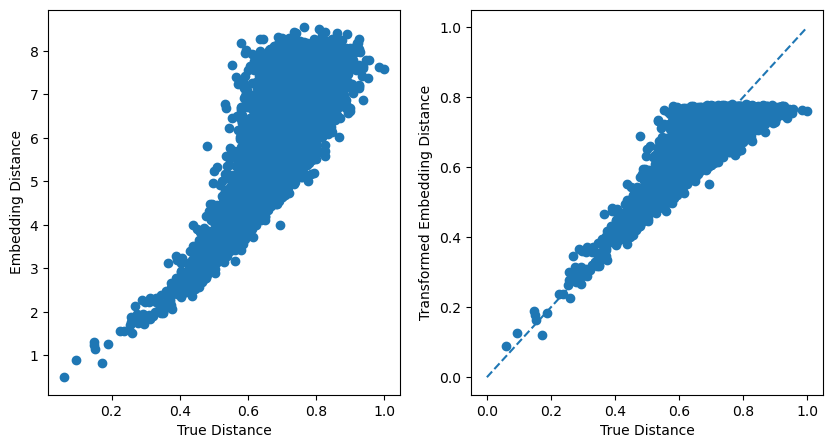

In [271]:
nmHMDS_noisy.shepard()

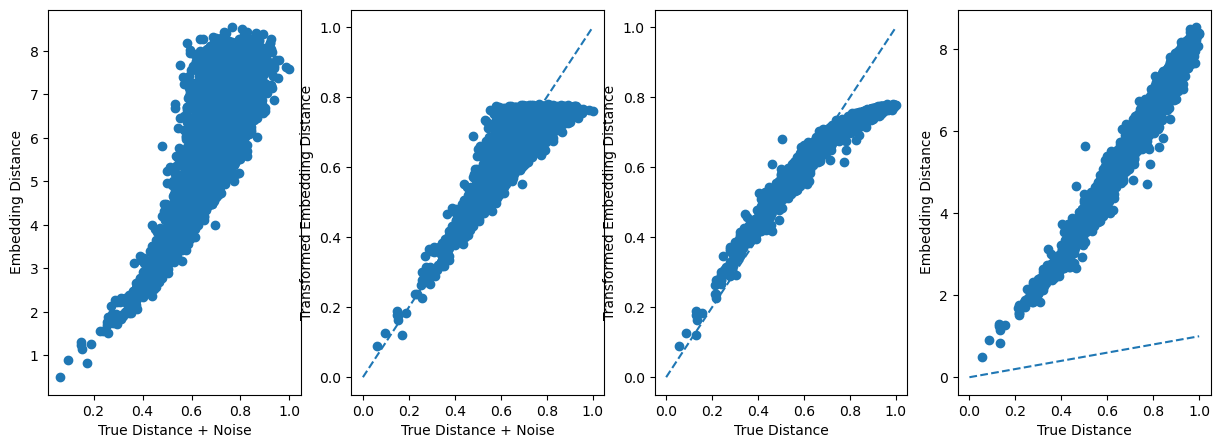

In [272]:
dmat = dmat/np.max(dmat)
fig, ax = plt.subplots(1, 4, figsize=(15,5))
ax[0].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[0].set_xlabel('True Distance + Noise')
ax[0].set_ylabel('Embedding Distance')
ax[1].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[1].plot([0,1],[0,1],linestyle='--')
ax[1].set_xlabel('True Distance + Noise')
ax[1].set_ylabel('Transformed Embedding Distance')
ax[2].scatter(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[2].plot([0,1],[0,1],linestyle='--')
ax[2].set_xlabel('True Distance')
ax[2].set_ylabel('Transformed Embedding Distance')
ax[3].scatter(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], (nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[3].plot([0,1],[0,1],linestyle='--')
ax[3].set_xlabel('True Distance')
ax[3].set_ylabel('Embedding Distance')
plt.show()

TypeError: in user code:

    File "/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_1104/3149351925.py", line 53, in monotonic  *
        dist_s = tf.expand_dims(x, axis=-1) - tf.math.exp(tf.expand_dims(self.log_s, axis=0))

    TypeError: Input 'y' of 'Sub' Op has type float32 that does not match type float64 of argument 'x'.


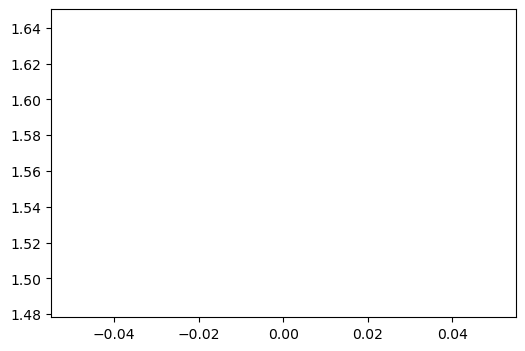

In [273]:
plt.figure(figsize=(6, 4))
plt.plot(dmat[i][j], 10*np.sin(np.pi/20),     label='Ground-truth sinusoid', lw=2)
plt.plot(dmat[i][j], nmHMDS_noisy.monotonic(dmat[i][j]),      label='Learned monotone $f$', lw=2)
plt.xlabel('Input distance  (normalised)')
plt.ylabel('Transformed distance')
plt.title('True vs learned monotonic transformation')
plt.legend()
plt.tight_layout()
plt.show()

In [232]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.7759740860749561,
 'Pearson Correlation': 0.8465817031918441,
 'R^2 Value': -2240.5640293279175}

In [233]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.7759739361002931,
 'Pearson Correlation': 0.875190293145758,
 'R^2 Value': 0.7659398694299686}

In [234]:
embedding_fit_metrics(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.9881227074614048,
 'Pearson Correlation': 0.963531497888269,
 'R^2 Value': 0.7043056775818028}

In [235]:
nmHMDS_noisy = nonmetricHMDS(Noisy_dmat,3,5)

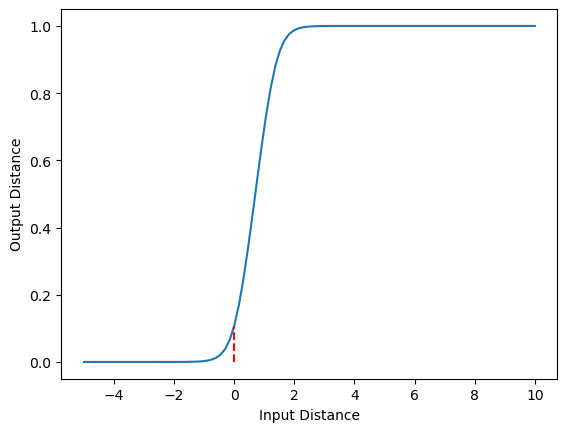

epoch 0, Loss: 6708.23291015625, normG: 228322.296875
epoch 5000, Loss: -6789.79150390625, normG: 321.8876037597656
epoch 10000, Loss: -7177.4404296875, normG: 68.03511810302734
epoch 15000, Loss: -7363.87841796875, normG: 2971.3115234375
epoch 20000, Loss: -7469.5576171875, normG: 171.99961853027344
epoch 25000, Loss: -7538.77294921875, normG: 7.806136131286621
epoch 30000, Loss: -7599.125, normG: 7.400942802429199
epoch 35000, Loss: -7642.88671875, normG: 433.27447509765625
epoch 40000, Loss: -7681.18017578125, normG: 6.725724220275879
epoch 45000, Loss: -7728.44140625, normG: 5985.31640625
31.234153985977173


In [236]:
now = time.time()
nmHMDS_noisy.train(n=50000)
print(time.time() - now)

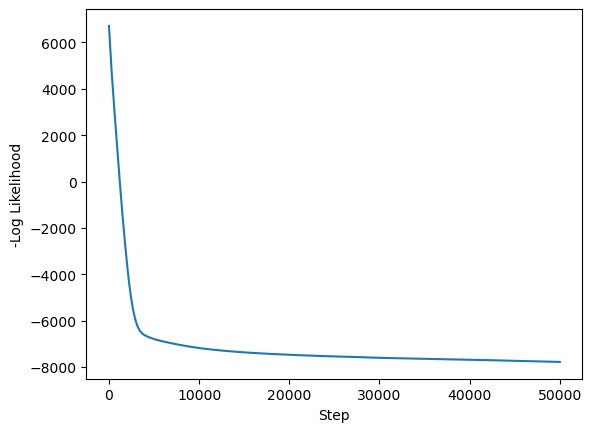

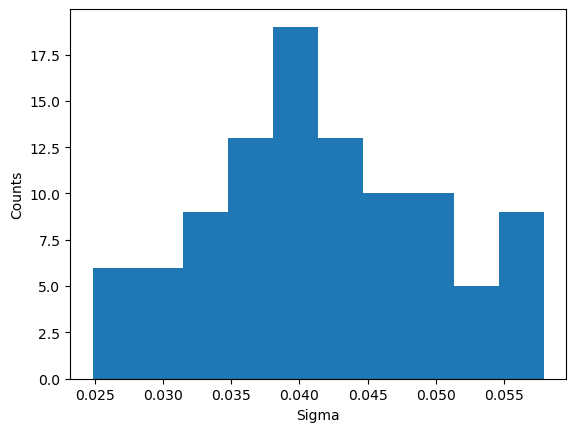

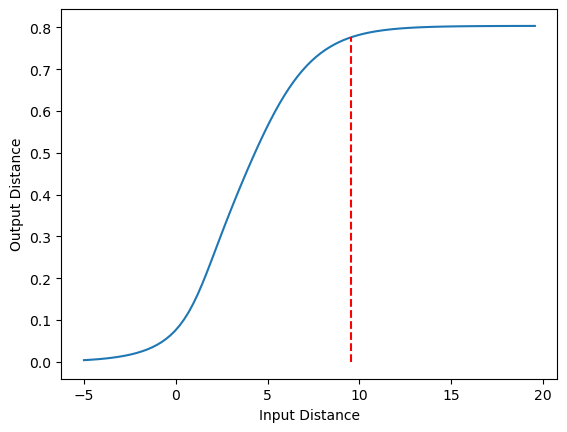

In [237]:
nmHMDS_noisy.plot_loss()
nmHMDS_noisy.plot_sigmas()
nmHMDS_noisy.plot_transformation()

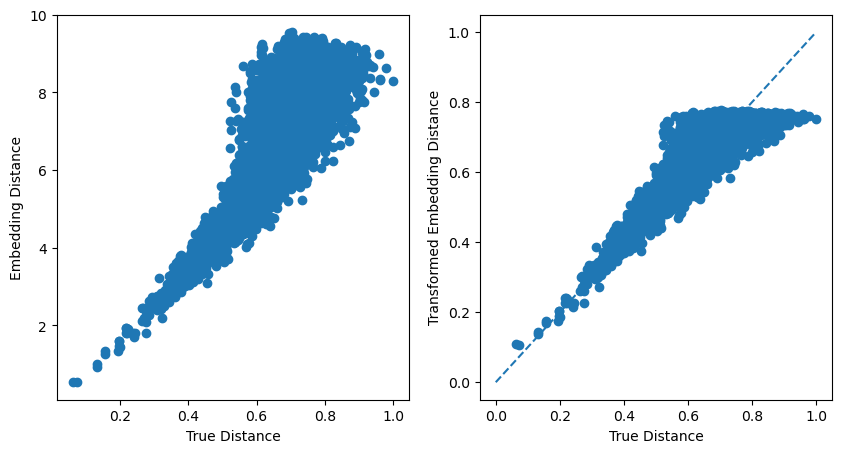

In [238]:
nmHMDS_noisy.shepard()

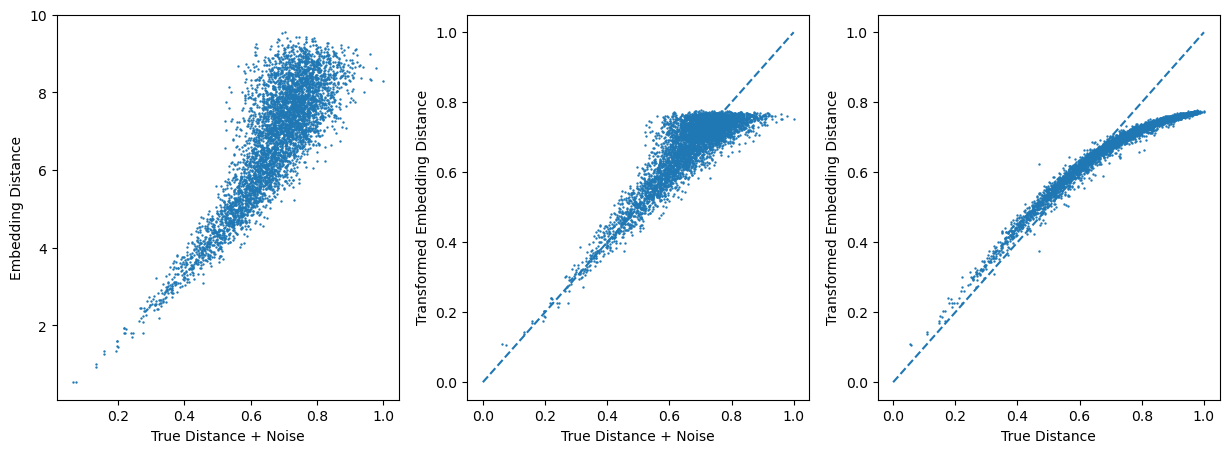

In [239]:
dmat = dmat/np.max(dmat)
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[0].set_xlabel('True Distance + Noise')
ax[0].set_ylabel('Embedding Distance')
ax[1].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[1].plot([0,1],[0,1],linestyle='--')
ax[1].set_xlabel('True Distance + Noise')
ax[1].set_ylabel('Transformed Embedding Distance')
ax[2].scatter(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[2].plot([0,1],[0,1],linestyle='--')
ax[2].set_xlabel('True Distance')
ax[2].set_ylabel('Transformed Embedding Distance')
plt.show()

In [240]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.7773997707795857,
 'Pearson Correlation': 0.8511909765755741,
 'R^2 Value': -2926.7267254944604}

In [241]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.7773997738631153,
 'Pearson Correlation': 0.8775562528570542,
 'R^2 Value': 0.7701032471715417}

In [242]:
embedding_fit_metrics(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.9916280761976076,
 'Pearson Correlation': 0.9665507234342674,
 'R^2 Value': 0.7100117940248414}

In [243]:
HMDS_noisy = HMDS(Noisy_dmat,3)

In [244]:
now = time.time()
HMDS_noisy.train(n=50000)
print(time.time() - now)

epoch 0, Loss: 6907.25537109375, normG: 176451.53125
epoch 5000, Loss: 3775.792236328125, normG: 247037.203125
epoch 10000, Loss: 1310.182373046875, normG: 216739.21875
epoch 15000, Loss: -754.0897827148438, normG: 139070.0
epoch 20000, Loss: -2042.287841796875, normG: 52228.53515625
epoch 25000, Loss: -2606.236083984375, normG: 334806.8125
epoch 30000, Loss: -3104.454345703125, normG: 53145.8359375
epoch 35000, Loss: -3339.00146484375, normG: 3136.966796875
epoch 40000, Loss: -3503.15478515625, normG: 2166.487548828125
epoch 45000, Loss: -3638.583984375, normG: 1603.9539794921875
15.071217060089111


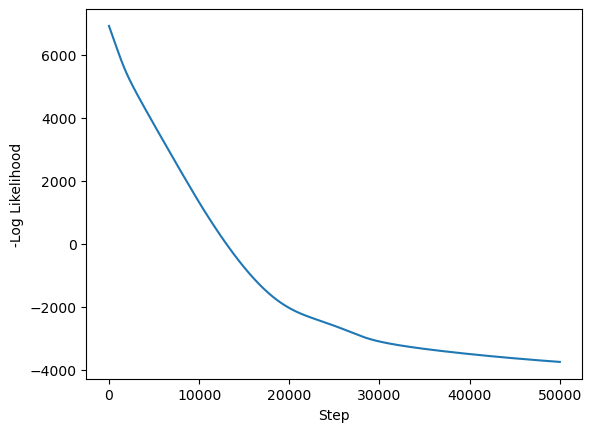

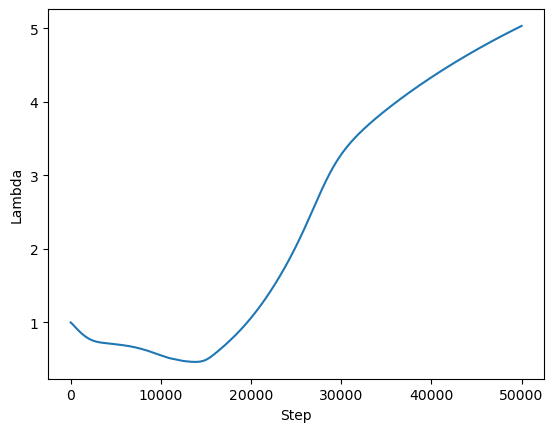

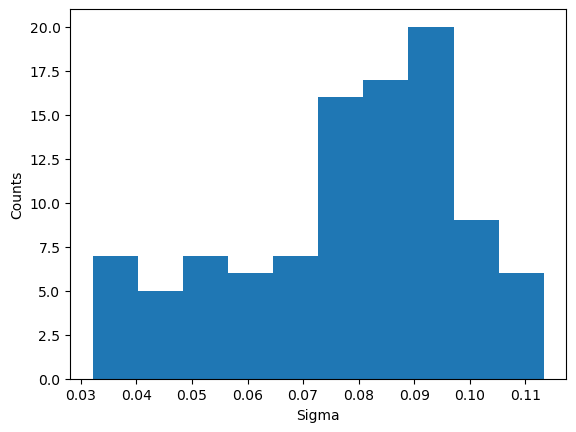

In [245]:
HMDS_noisy.plot_loss()
HMDS_noisy.plot_lambda()
HMDS_noisy.plot_sigmas()

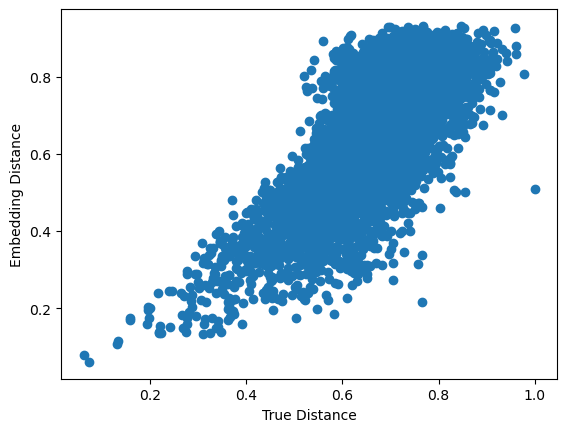

In [246]:
HMDS_noisy.shepard()

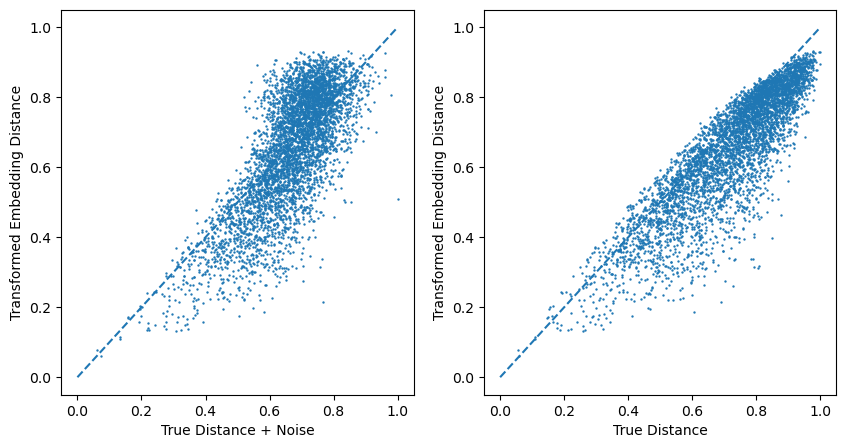

In [247]:
dmat = dmat/np.max(dmat)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(Noisy_dmat[np.triu_indices(HMDS_noisy.N,k=1)], HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam),s=0.5)
ax[0].plot([0,1],[0,1],linestyle='--')
ax[0].set_xlabel('True Distance + Noise')
ax[0].set_ylabel('Transformed Embedding Distance')
ax[1].scatter(dmat[np.triu_indices(HMDS_noisy.N,k=1)], HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam),s=0.5)
ax[1].plot([0,1],[0,1],linestyle='--')
ax[1].set_xlabel('True Distance')
ax[1].set_ylabel('Transformed Embedding Distance')
plt.show()

In [248]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(HMDS_noisy.N,k=1)],HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam))

{'Spearman Rank Correlation': 0.6964731856370914,
 'Pearson Correlation': 0.7534820208070863,
 'R^2 Value': 0.05101263859007921}

In [249]:
embedding_fit_metrics(dmat[np.triu_indices(HMDS_noisy.N,k=1)],HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam))

{'Spearman Rank Correlation': 0.870152849124552,
 'Pearson Correlation': 0.8728295917959146,
 'R^2 Value': 0.5549375574141419}

In [250]:
nmHMDS_noisy = nonmetricHMDS(Noisy_dmat,3,5)

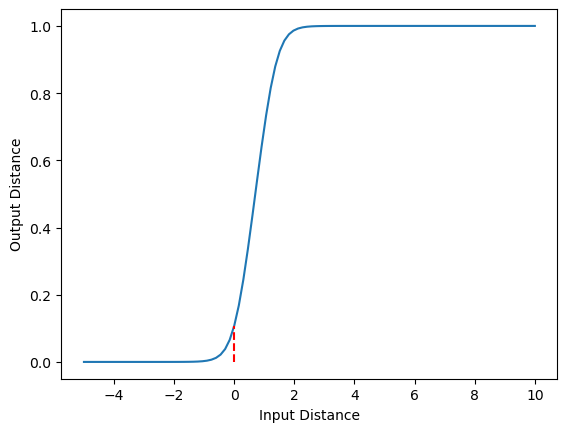

epoch 0, Loss: 6708.9775390625, normG: 228311.34375
epoch 5000, Loss: -6546.56982421875, normG: 249.8016357421875
epoch 10000, Loss: -6925.5966796875, normG: 66.3892822265625
epoch 15000, Loss: -7123.62451171875, normG: 26.1877498626709
epoch 20000, Loss: -7248.62255859375, normG: 18.137420654296875
epoch 25000, Loss: -7345.59521484375, normG: 260.4062805175781
epoch 30000, Loss: -7421.06787109375, normG: 10.069986343383789
epoch 35000, Loss: -7484.9443359375, normG: 9.960782051086426
epoch 40000, Loss: -7542.20654296875, normG: 15.434718132019043
epoch 45000, Loss: -7595.55419921875, normG: 4503.59912109375
32.47293281555176


In [251]:
now = time.time()
nmHMDS_noisy.train(n=50000)
print(time.time() - now)

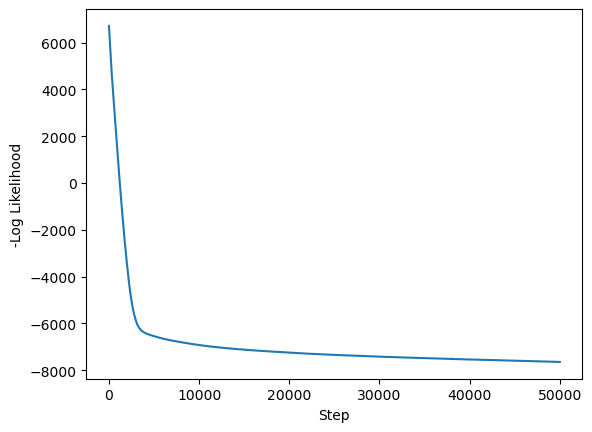

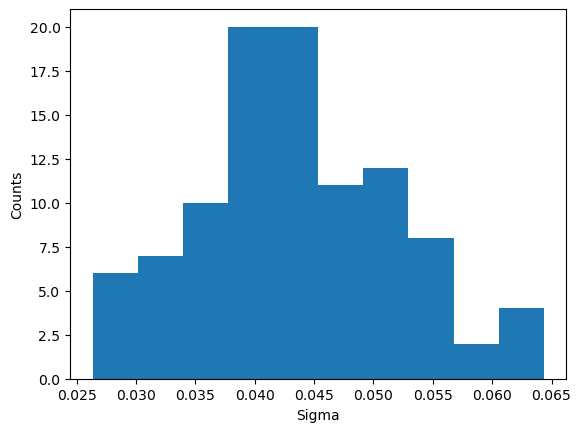

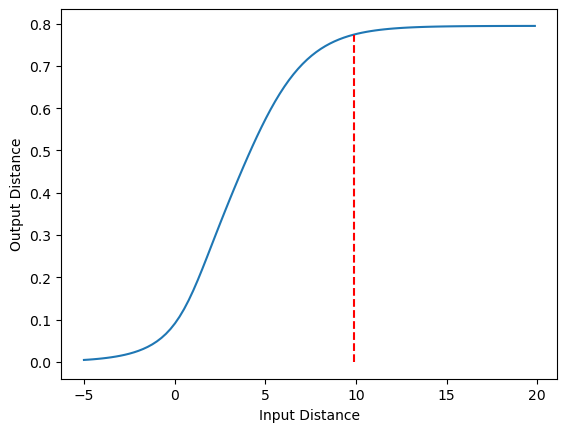

In [252]:
nmHMDS_noisy.plot_loss()
nmHMDS_noisy.plot_sigmas()
nmHMDS_noisy.plot_transformation()

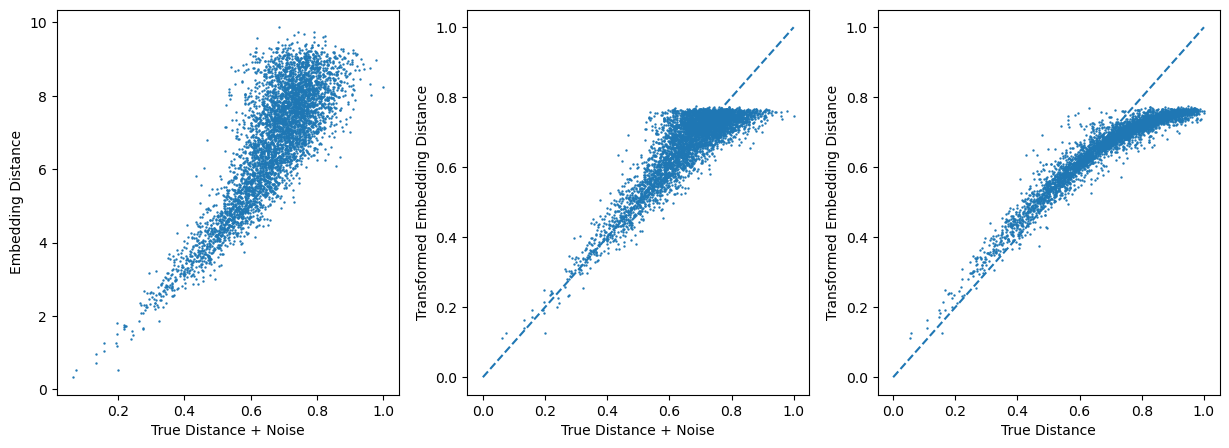

In [253]:
dmat = dmat/np.max(dmat)
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[0].set_xlabel('True Distance + Noise')
ax[0].set_ylabel('Embedding Distance')
ax[1].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[1].plot([0,1],[0,1],linestyle='--')
ax[1].set_xlabel('True Distance + Noise')
ax[1].set_ylabel('Transformed Embedding Distance')
ax[2].scatter(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)],s=0.5)
ax[2].plot([0,1],[0,1],linestyle='--')
ax[2].set_xlabel('True Distance')
ax[2].set_ylabel('Transformed Embedding Distance')
plt.show()

In [254]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.7539303178275302,
 'Pearson Correlation': 0.8319690873995254,
 'R^2 Value': -2943.853990794256}

In [255]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.7539302961048147,
 'Pearson Correlation': 0.8628968232794058,
 'R^2 Value': 0.7445880710809907}

In [256]:
embedding_fit_metrics(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)],nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])

{'Spearman Rank Correlation': 0.954877719002761,
 'Pearson Correlation': 0.9449522111499058,
 'R^2 Value': 0.6765526242662552}

In [257]:
HMDS_noisy = HMDS(Noisy_dmat,3)

In [258]:
now = time.time()
HMDS_noisy.train(n=50000)
print(time.time() - now)

epoch 0, Loss: 6906.40869140625, normG: 176435.5625
epoch 5000, Loss: 3782.390625, normG: 245631.484375
epoch 10000, Loss: 1328.031005859375, normG: 213560.921875
epoch 15000, Loss: -727.530517578125, normG: 136554.28125
epoch 20000, Loss: -2030.0291748046875, normG: 46498.890625
epoch 25000, Loss: -2545.821533203125, normG: 225587.625
epoch 30000, Loss: -3027.670166015625, normG: 115413.3046875
epoch 35000, Loss: -3286.478759765625, normG: 3552.319091796875
epoch 40000, Loss: -3459.096923828125, normG: 2380.369384765625
epoch 45000, Loss: -3601.462646484375, normG: 1759.138671875
15.802819967269897


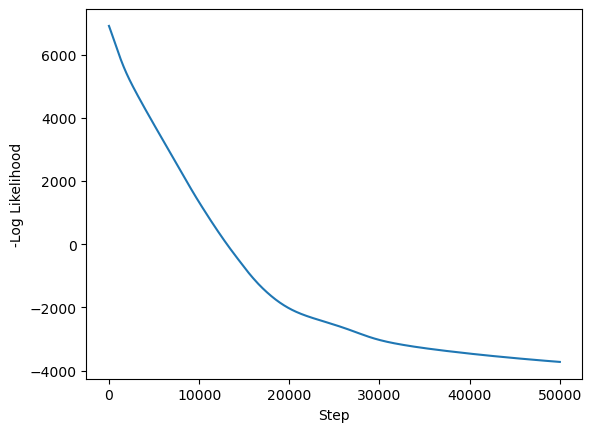

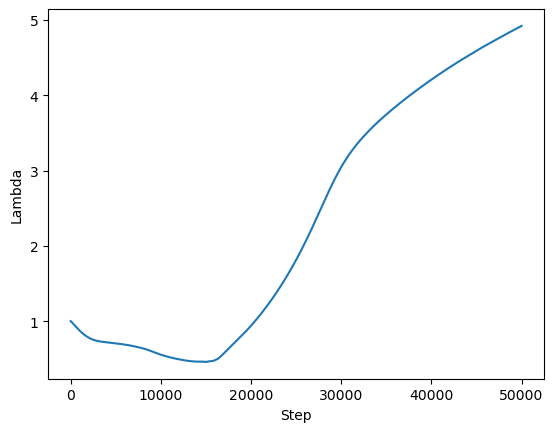

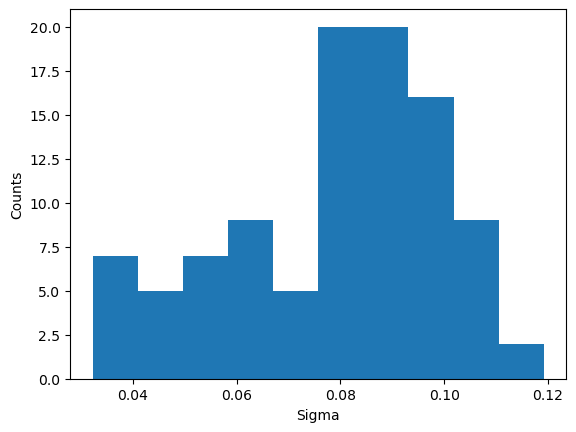

In [259]:
HMDS_noisy.plot_loss()
HMDS_noisy.plot_lambda()
HMDS_noisy.plot_sigmas()

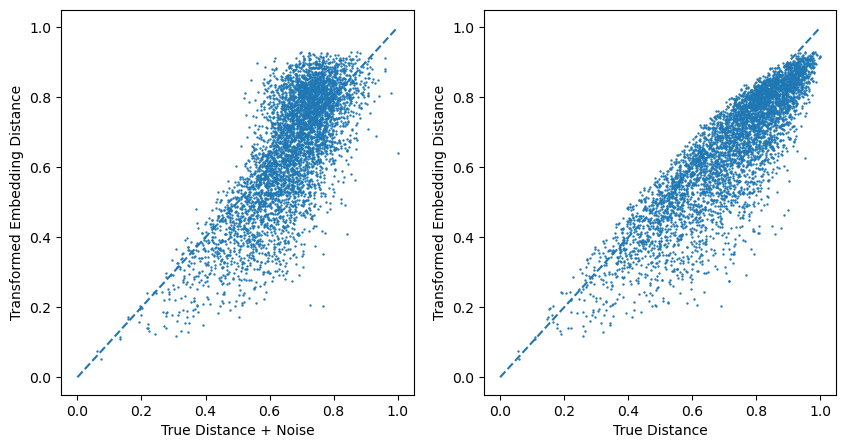

In [260]:
dmat = dmat/np.max(dmat)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(Noisy_dmat[np.triu_indices(HMDS_noisy.N,k=1)], HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam),s=0.5)
ax[0].plot([0,1],[0,1],linestyle='--')
ax[0].set_xlabel('True Distance + Noise')
ax[0].set_ylabel('Transformed Embedding Distance')
ax[1].scatter(dmat[np.triu_indices(HMDS_noisy.N,k=1)], HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam),s=0.5)
ax[1].plot([0,1],[0,1],linestyle='--')
ax[1].set_xlabel('True Distance')
ax[1].set_ylabel('Transformed Embedding Distance')
plt.show()

In [261]:
embedding_fit_metrics(Noisy_dmat[np.triu_indices(HMDS_noisy.N,k=1)],HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam))

{'Spearman Rank Correlation': 0.6953040070329872,
 'Pearson Correlation': 0.7513440349322791,
 'R^2 Value': 0.026987260112411038}

In [262]:
embedding_fit_metrics(dmat[np.triu_indices(HMDS_noisy.N,k=1)],HMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(HMDS_noisy.N,k=1)]/np.exp(HMDS_noisy.log_lam))

{'Spearman Rank Correlation': 0.86742557079468,
 'Pearson Correlation': 0.8706975522387173,
 'R^2 Value': 0.5448360091389766}